In [ ]:
%pylab inline
import numpy.linalg as LA
from time import time
import pandas as pd
import os
import numpy as np

from scipy.sparse.linalg import spsolve
from scipy import sparse


Populating the interactive namespace from numpy and matplotlib





# Part 1: Matrix Factorization for Movie Lens Recommendations



### Data preparation (Read carefully!)
Here we  will look at a portion of the  movie rating dataset, which
has ratings that users have given to movies. It is a dataset of 1 million movie ratings (from 1 to 5) available from the MovieLens project. The MovieLens datasets were created collected by GroupLens Research at the University of Minnesota.

We want to include the metadata (movie titles, etc), not just the ratings matrix.

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m
!ls
folder = 'ml-1m'

--2024-04-14 02:10:52--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  11.3MB/s    in 0.5s    

2024-04-14 02:10:53 (11.3 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
ml-1m  ml-1m.zip  sample_data


In [ ]:

ratings_list = [ [int(x) for x in i.strip().split("::")] for i in open(os.path.join(folder,'ratings.dat'), 'r').readlines()]
users_list = [i.strip().split("::") for i in open(os.path.join(folder, 'users.dat'), 'r').readlines()]
movies_list = [i.strip().split("::") for i in open(os.path.join(folder, 'movies.dat'), 'r',  encoding="latin-1").readlines()]

ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)

In [ ]:
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
def get_movie_name(movies_df, movie_id_str):
  ndx = (movies_df['MovieID']==int(movie_id_str))
  name = movies_df['Title'][ndx].to_numpy()[0]
  return name

def get_movie_genres(movies_df, movie_id_str):
  ndx = (movies_df['MovieID']==int(movie_id_str))
  name = movies_df['Genres'][ndx].to_numpy()[0]
  return name

print('Movie with Moive ID 1 is ', get_movie_name(movies_df, 1))
print('The corresponding genres is ',get_movie_genres(movies_df, 1))
print('Movie with Moive ID 527 is ', get_movie_name(movies_df, "527"))
print('The corresponding genres is ', get_movie_genres(movies_df, "527"))

Movie with Moive ID 1 is  Toy Story (1995)
The corresponding genres is  Animation|Children's|Comedy
Movie with Moive ID 527 is  Schindler's List (1993)
The corresponding genres is  Drama|War


In [ ]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


These look good, but I want the format of my ratings matrix to be one row per user and one column per movie. I'll `pivot` `ratings_df` to get that and call the new variable `R`.

In [ ]:
R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
R_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
R = R_df.to_numpy()
R.shape

(6040, 3706)

Similarly we mask a random sample of the user/item ratings to validate and compare how well the recommender system did in predicting the ratings of those masked values. In our case, given we already know each user has given more than 10 ratings, what we'll do is for every user, we remove 10 of the item ratings and and assign them to the test set.

In [ ]:
def create_train_test(R):
    """
    split into training and test sets,
    remove 5 ratings from each user
    and assign them to the test set
    """
    test = np.zeros(R.shape)
    train = R.copy()
    for user in range(R.shape[0]):
        test_index = np.random.choice(
            np.flatnonzero(R[user]), size = 5, replace = False)

        train[user, test_index] = 0.0
        test[user, test_index] = R[user, test_index]

    # assert that training and testing set are truly disjoint
    assert np.all(train * test == 0)
    return train, test

Rtrain, Rtest = create_train_test(R)



---


##  SVD (
The simpliest matrix factorization method is SVD.

### **Our task:**
- Each row(user) subtract by each user mean, which normalize each user rating.

- Perform SVD on the normalized `R` and choose the latent factors $k=10,30,50$.

- Calculate the rank=$k$ approximation of $R$. You also need to add the user means back to get the actual ratings prediction, denote this rating matrix as `R_k`

- Now some of entries may be out of rating range $[0,5]$. Please set entries that are larger than 5 to 5 and set entries that are smaller than 0 to 0.

- Compute MSE for training and testing dataset in all three $k$ situations. Which $k$ performs the best in testing dataset?  You need to use the MSE function used in the class.


In [ ]:
def compute_mse(train, pred):
    train_ravel = train.ravel()
    pred_ravel  = pred.ravel()
    mask = np.nonzero(train_ravel)
    mse = np.sqrt(np.sum( (train_ravel[mask]- pred_ravel[mask])**2 )/np.shape(mask)[1])
    return mse

user_means = np.mean(Rtrain, axis=1, keepdims=True)
R_normalized = Rtrain - user_means

In [ ]:
ks = [10, 30, 50]
mse_results = []

for k in ks:
    U, sigma, Vt = np.linalg.svd(R_normalized, full_matrices=False)
    Sk = np.diag(sigma[:k])
    Uk = U[:, :k]
    Vk = Vt[:k, :]
    R_k = np.dot(np.dot(Uk, Sk), Vk)

    R_pred = R_k + user_means

    R_pred = np.clip(R_pred, 0, 5)

    mse_train = compute_mse(Rtrain, R_pred)
    mse_test = compute_mse(Rtest, R_pred)

    mse_results.append((k, mse_train, mse_test))

mse_results_df = pd.DataFrame(mse_results, columns=['k', 'MSE_Train', 'MSE_Test'])
print(mse_results_df)

best_k = mse_results_df.loc[mse_results_df['MSE_Test'].idxmin()]['k']
print("Best k based on MSE_Test:", best_k)


    k  MSE_Train  MSE_Test
0  10   2.538928  3.075519
1  30   2.344662  2.931291
2  50   2.243402  2.910058
Best k based on MSE_Test: 50.0


### Make Movie Recommendations
Finally, it's time. With the predictions matrix for every user, I can build a function to recommend movies for any user. All I need to do is return the movies with the highest predicted rating that the specified user hasn't already rated. Though I didn't use actually use any explicit movie content features (such as genre or title), I'll merge in that information to get a more complete picture of the recommendations.

I'll also return the list of movies the user has already rated, for the sake of comparison.

In [ ]:
def recommend_movies(preds_df, userID, movies_df, original_ratings_df, num_recommendations=5):

    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1

    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.UserID == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'MovieID', right_on = 'MovieID').
                     sort_values(['Rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))

    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['MovieID'].isin(user_full['MovieID'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'MovieID',
               right_on = 'MovieID').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [ ]:
# R_k with optimal k is the low rank matrix you have constructed previously
preds_df = pd.DataFrame(R_k, columns = R_df.columns)
preds_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.333736,0.063830,-0.223192,-0.095240,-0.035339,-0.124119,-0.131709,0.071957,-0.128026,-0.230876,...,-0.051805,-0.042477,-0.023946,-0.074845,-0.153434,0.425196,0.057898,-0.000635,0.002375,0.022144
1,0.644075,0.089041,0.113265,-0.136882,-0.093302,1.047851,-0.192288,-0.040383,0.008185,1.260642,...,-0.176418,-0.136772,-0.131660,-0.059830,-0.135232,0.025959,-0.525968,-0.206533,-0.187873,-0.224421
2,1.571551,0.392007,0.023788,-0.119376,-0.080193,-0.118276,-0.140197,0.054478,-0.008096,0.691326,...,-0.000393,-0.056825,-0.037219,-0.016095,-0.018518,0.103224,0.087843,-0.004570,-0.041116,-0.140812
3,0.507267,0.043324,-0.017370,0.063559,0.024974,0.103879,-0.049361,-0.009832,0.032755,-0.210601,...,-0.046966,-0.012231,-0.018214,-0.019434,-0.112199,0.017585,-0.106291,-0.053150,-0.018334,-0.123231
4,1.423394,-0.147810,-0.186172,0.075904,-0.202279,1.284392,-0.371672,-0.195186,-0.232014,0.306346,...,-0.056616,-0.123010,-0.161637,-0.189912,-0.234308,-0.208913,0.340378,-0.142346,-0.021811,0.020201


In [ ]:
# Let's check for user 837
already_rated, predictions = recommend_movies(preds_df, 837, movies_df, ratings_df, 10)
already_rated.head(10)


User 837 has already rated 69 movies.
Recommending highest 10 predicted ratings movies not already rated.


,UserID,MovieID,Rating,Timestamp,Title,Genres
36,837,858,5,975360036,"Godfather, The (1972)",Action|Crime|Drama
35,837,1387,5,975360036,Jaws (1975),Action|Horror
65,837,2028,5,975360089,Saving Private Ryan (1998),Action|Drama|War
63,837,1221,5,975360036,"Godfather: Part II, The (1974)",Action|Crime|Drama
11,837,913,5,975359921,"Maltese Falcon, The (1941)",Film-Noir|Mystery
20,837,3417,5,975360893,"Crimson Pirate, The (1952)",Adventure|Comedy|Sci-Fi
34,837,2186,4,975359955,Strangers on a Train (1951),Film-Noir|Thriller
55,837,2791,4,975360893,Airplane! (1980),Comedy
31,837,1188,4,975360920,Strictly Ballroom (1992),Comedy|Romance
28,837,1304,4,975360058,Butch Cassidy and the Sundance Kid (1969),Action|Comedy|Western


In [ ]:
# here is your prediction. Does it make sense? please comment your result.
predictions

,MovieID,Title,Genres
1848,1953,"French Connection, The (1971)",Action|Crime|Drama|Thriller
516,527,Schindler's List (1993),Drama|War
596,608,Fargo (1996),Crime|Drama|Thriller
581,593,"Silence of the Lambs, The (1991)",Drama|Thriller
2085,2194,"Untouchables, The (1987)",Action|Crime|Drama
1188,1230,Annie Hall (1977),Comedy|Romance
885,908,North by Northwest (1959),Drama|Thriller
1198,1242,Glory (1989),Action|Drama|War
1161,1198,Raiders of the Lost Ark (1981),Action|Adventure
1849,1954,Rocky (1976),Action|Drama


    k  MSE_Train  MSE_Test                                                                   
0  10   2.538928  3.075519                                                                                   
1  30   2.344662  2.931291                                                                                   
2  50   2.243402  2.910058                                                                            
Best k based on MSE_Test: 50.0                                                               
These predictions make sense.



---


## : Non-negative matrix
$W$ and $H$ values in matrix Factorization are non interpretable since their components can take arbitrary (positive and negative) values.

The objective function of non-negative matrix factorization is
\begin{align}
\min_{W\in \mb{R}^{M\times k}, H\in \mb{R}^{N\times k}} \|A-WH^\top\|_F^2 + \lambda \left(\|W\|_F^2 + \|H\|_F^2\right), \text{ subject to } W\ge 0, H\ge 0.
\end{align}

### **Our task:**
- Implement Lee and Seung's multiplicative update rule as discussed in the notebook, with the latent factor $k=10$ and $\lambda=0.6$

- Compute MSE for training and testing dataset. You need to use the MSE function used in class.

- Please check your recommendation prediction for the user 837. Does it make sense?

- Check the matrix $W$, does it fit the preference of genres for the user? You can cross-check some rows.

- Check the matrix $H$, does it fit the description of genres for the movie? You can cross-check some rows.




In [ ]:
def nmf_multiplicative_update(A, k, max_iter=100, tol=1e-5, lmbda=0.6):
    M, N = A.shape
    W = np.random.rand(M, k)
    H = np.random.rand(N, k)

    for iter in range(max_iter):
        # Update W
        AH = np.dot(A, H)
        WHtH = np.dot(np.dot(W, H.T), H)
        W_new = W * AH / (lmbda * W + WHtH + 1e-9)

        # Update H
        WtA = np.dot(W.T, A)
        WtWHt = np.dot(np.dot(W.T, W), H.T)
        H_new = H * (WtA.T) / (lmbda * H + WtWHt.T + 1e-9)

        norm_diff = np.linalg.norm(W_new - W) + np.linalg.norm(H_new - H)
        W = W_new
        H = H_new

        if norm_diff < tol:
            break

    return W, H

In [ ]:
k = 10
W, H = nmf_multiplicative_update(Rtrain, k)

def compute_mse(train, pred):
    train_ravel = train.ravel()
    pred_ravel = pred.ravel()
    mask = np.nonzero(train_ravel)
    mse = np.sqrt(np.sum((train_ravel[mask] - pred_ravel[mask])**2) / np.shape(mask)[1])
    return mse

R_pred_train = np.dot(W, H.T)
mse_train = compute_mse(Rtrain, R_pred_train)

R_pred_test = np.dot(W, H.T)
mse_test = compute_mse(Rtest, R_pred_test)

print("MSE for training dataset:", mse_train)
print("MSE for testing dataset:", mse_test)


MSE for training dataset: 11.644659873150726
MSE for testing dataset: 7.786180232735986


In [ ]:
user_full, recommendations = recommend_movies(pd.DataFrame(R_pred, columns=R_df.columns), 837, movies_df, ratings_df, num_recommendations=10)

print("User 837 has already rated {} movies.".format(user_full.shape[0]))
print("Recommended movies for user 837 based on predicted ratings:")
print(recommendations)


User 837 has already rated 69 movies.
Recommending highest 10 predicted ratings movies not already rated.
User 837 has already rated 69 movies.
Recommended movies for user 837 based on predicted ratings:
      MovieID                             Title                       Genres
1848     1953     French Connection, The (1971)  Action|Crime|Drama|Thriller
516       527           Schindler's List (1993)                    Drama|War
596       608                      Fargo (1996)         Crime|Drama|Thriller
581       593  Silence of the Lambs, The (1991)               Drama|Thriller
2085     2194          Untouchables, The (1987)           Action|Crime|Drama
1188     1230                 Annie Hall (1977)               Comedy|Romance
885       908         North by Northwest (1959)               Drama|Thriller
1198     1242                      Glory (1989)             Action|Drama|War
1161     1198    Raiders of the Lost Ark (1981)             Action|Adventure
1849     1954             

In [ ]:
print("\nMatrix W:")
print(W)

print("\nMatrix H:")
print(H)



Matrix W:
[[2.90793480e-01 2.85903423e-01 1.58091248e-02 ... 5.70324398e-14
  5.29577168e-02 4.39211961e-03]
 [1.54325444e+00 3.09864389e-12 5.90073602e-01 ... 1.49948468e-01
  8.07585712e-12 7.52877184e-01]
 [8.42833006e-01 1.56297928e-04 8.10745807e-04 ... 8.49586141e-31
  6.42996616e-01 1.03486303e-27]
 ...
 [3.08643775e-02 6.93770773e-02 1.51591283e-01 ... 9.14450274e-07
  5.23533895e-02 5.04194923e-10]
 [4.57968914e-15 2.40684465e-04 2.21175291e+00 ... 1.29105193e-19
  3.38408338e-10 2.48261200e-24]
 [6.12902931e-01 1.18369925e+00 2.40352786e+00 ... 2.96968823e+00
  2.99920631e-01 7.44548189e-07]]

Matrix H:
[[3.25060851e+00 4.99753967e+00 8.59337808e-01 ... 3.01150115e-06
  3.80356479e+00 2.93655268e+00]
 [7.41611450e-03 3.97513279e-07 3.29905249e-07 ... 1.46557230e-02
  3.29001397e-02 3.05930206e-02]
 [1.29295230e-07 7.92364418e-11 6.03467614e-06 ... 1.77193610e-14
  1.13637339e+00 1.38280138e+00]
 ...
 [6.04160752e-09 2.48168037e-01 2.84019455e-03 ... 4.09369368e-01
  4.751763

MSE for training dataset: 11.644659873150726


MSE for testing dataset: 7.786180232735986



---
## Your task: Freeride (35pt)
Implement any algorithm you’d like (you must implement it yourself; do not use an off-the-shelf algorithm) to find an estimator that achieves a test MSE error better than these in warm up tasks. You need to use the MSE function used in class. However, you may use all machine learning modules we learnt in this course.


In [ ]:
# Look into data
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


We see here, that its a very basic list. Not much we can do right off the bat except remove the timestamp column. We wouldn't be needing that as we are focused on the ratings not the timestamp.

In [ ]:
ratings_df = ratings_df.drop('Timestamp', axis=1)
ratings_df

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


Let's analyze the ratings_df more now. Looking at the placements of ratings to see if there are any outliers compared to the movie titles.

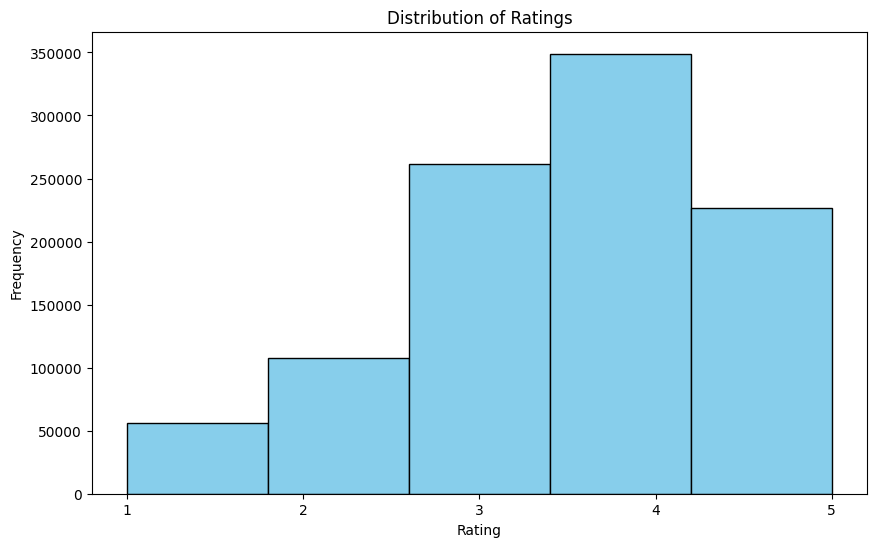

In [ ]:
average_ratings = ratings_df.groupby('MovieID')['Rating'].mean()
plt.figure(figsize=(10, 6))
plt.hist(ratings_df['Rating'], bins=5, color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))
plt.show()

Looking at this distribution, we see that it seems evenly placed out except the ones that are in the 1-2 rating zone. Logically, there won't be any outliers here because clearly from a scale of 1-5 theres several users who have rated each rating.

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64


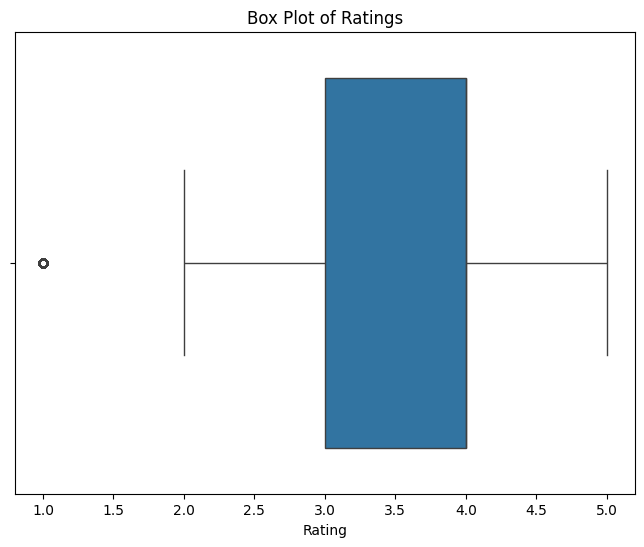

In [ ]:
import seaborn as sns
print(ratings_df['Rating'].describe())
plt.figure(figsize=(8, 6))
sns.boxplot(x=ratings_df['Rating'])
plt.title('Box Plot of Ratings')
plt.xlabel('Rating')
plt.show()

Looking at this boxplot, clearly there are outliers for 1.0. But, it doesn't make sense to remove them. Removing them will cause bias in the data as we have millions of rows where several are in the 1.0 zone. If we remove it, we will be directly impacting the data as there aren't a lot of ratings that we can put and we remove a full category.

We can now divert our attention to the movies dataset and see if there are any outliers there.

In [ ]:
movies_df

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


A good starting point here will be looking at if there are any genres that are a one-off.

In [ ]:
genres_split = movies_df['Genres'].str.split('|')
all_genres = []
for genre_list in genres_split:
    all_genres.extend(genre_list)
genre_counts = {}
for genre in all_genres:
    genre_counts[genre] = genre_counts.get(genre, 0) + 1
for genre, count in genre_counts.items():
    print(f"{genre}\t\t{count}")

Animation		105
Children's		251
Comedy		1200
Adventure		283
Fantasy		68
Romance		471
Drama		1603
Action		503
Crime		211
Thriller		492
Horror		343
Sci-Fi		276
Documentary		127
War		143
Musical		114
Mystery		106
Film-Noir		44
Western		68


Does not seem like there are any outliers here. All the genres have a substanial amount of movies in them. Removing them would cause a huge loss to the data and our MSE after would not be perfect.

We can start by implementing different Machine Learning models now. Let's start with a easy one:

Let us implement a algorithm here called UserAverage. This one predict's a user rating for an item based on the average of all ratings that a user has given.

Now we have to think about the fact that this is a very simple algorithm, without taking anything into consideration. We will use this as a base model to compare to other ones that we develop.


In [ ]:
class UserAverage:
    def __init__(self):
        self.user_averages = None

    def fit(self, train):
        self.user_averages = np.nanmean(np.where(train > 0, train, np.nan), axis=1)

    def predict_all(self, shape):
        return np.tile(self.user_averages, (shape[1], 1)).T

def compute_mse(train, pred):
    train_ravel = train.ravel()
    pred_ravel  = pred.ravel()
    mask = np.nonzero(train_ravel)
    mse = np.sqrt(np.sum((train_ravel[mask] - pred_ravel[mask])**2) / np.shape(mask)[1])
    return mse

model = UserAverage()
model.fit(Rtrain)
predictions = model.predict_all(Rtrain.shape)
mse = compute_mse(Rtrain, predictions)
print("MSE on training data:", mse)

MSE on training data: 1.0284790245671218


We can see that the MSE from this one is 1.02. Just to go over the the 2 functions, the function fit computes the average rating for each user. Any user that has a NaN is automatically converted to 0 for the calculation purposes. The predict function here provides prediction based on the user's average rating.

Keeping in mind this is a base model with nothing taken into consideration. Now, we can go one step up and implement a more complex model that take some characteristics into consideration.

In [ ]:
class UserAverageEnhanced:
    def __init__(self, damping_factor=5):
        self.user_averages = None
        self.damping_factor = damping_factor

    def fit(self, train):
        user_rating_counts = np.count_nonzero(train, axis=1)
        total_ratings = np.sum(train, axis=1)
        weighted_avgs = total_ratings / (user_rating_counts + self.damping_factor)
        self.user_averages = weighted_avgs

    def predict(self, userss, itemss):
        return self.user_averages[userss]

    def predict_all(self, shape):
        return np.tile(self.user_averages, (shape[1], 1)).T

def compute_mse(train, pred):
    train_ravel = train.ravel()
    pred_ravel = pred.ravel()
    mask = np.nonzero(train_ravel)
    mse = np.sqrt(np.sum((train_ravel[mask] - pred_ravel[mask])**2) / np.shape(mask)[1])
    return mse

predictions = model.predict_all(Rtest.shape)
mse = compute_mse(Rtest, predictions)
print("MSE on test data:", mse)

MSE on test data: 1.0363217891373029


From implementing user behavior into this, we can see that the MSE has only gone up slightly. We modified the user average to include a weighted scheme that adjusts each user's influence based on their activity level. This is good news!

Now we can shift paddles, and look at Collaborative Filtering as a model and implement our own.

In [ ]:
class CollaborativeFilteringOne:
    def __init__(self):
        self.global_average = 0

    def fit(self, train):
        self.global_average = np.sum(train) / np.count_nonzero(train)

    def predict(self):
        return self.global_average

def compute_mse(train, pred):
    train_ravel = train.ravel()
    pred_ravel = pred.ravel()
    mask = np.nonzero(train_ravel)
    mse = np.sqrt(np.sum((train_ravel[mask] - pred_ravel[mask])**2) / np.shape(mask)[1])
    return mse

model = CollaborativeFilteringOne()
model.fit(Rtrain)
global_avg_prediction = model.predict()
predictions = np.full_like(Rtrain, global_avg_prediction)
mse = compute_mse(Rtrain, predictions)
print("MSE for the Base Collabrative Filtering Model:", mse)

MSE for the Base Collabrative Filtering Model: 1.1171763020720642


This gives us a base MSE of 1.117. Now keep in mind this does not take any user behavior or item characteristics into consideration. This is pretty good considering we only take the base model. Now let's implement it with all characteristics and behavior taken into consideration.

In [ ]:
class CollaborativeFiltering:
    # regular init function
    def __init__(self, factors=10, interations=10, alpha=0.01, beta=0.01):
        self.factors = factors
        self.interations = interations
        self.alpha = alpha
        self.beta = beta

    # This function fits the collabrative filtering model to the provided training data
    def fit(self, train):
        # number of users and items in the training data
        n_users, n_items = train.shape
        # initiatilize factors with normal distribution centered around 0
        self.user_factors = np.random.normal(size=(n_users, self.factors))
        self.item_factors = np.random.normal(size=(n_items, self.factors))
        # user and item biases become 0
        self.user_biases = np.zeros(n_users)
        self.item_biases = np.zeros(n_items)
        # optimize factors and biases
        for _ in range(self.interations):
            # update item and users factors and biases
            for i in range(n_items):
                self.item_factors[i] = self.update_item_factors(train, i)
            for u in range(n_users):
                self.user_factors[u] = self.update_user_factors(train, u)

    # This function updates the latent factor vector for the specific item that is being observed
    def update_item_factors(self, train, numberofitems):
        # ratings for items across users
        ratings = train[:, numberofitems]
        # which users have rated this item
        nzindices = np.nonzero(ratings)
        users = nzindices[0]
        # actual ratings from the above indicies
        ratings = ratings[nzindices]
        # extracts user factors from users
        X = self.user_factors[users]
        # target value for regression
        y = ratings
        # formulate regularized lease square problem
        A = np.dot(X.T, X) + self.beta * np.eye(self.factors)
        B = np.dot(X.T, y)
        item_factors = np.linalg.solve(A, B)
        return item_factors

    # This function updates the latent factor vector for the specific user that is being observed
    def update_user_factors(self, train, extra):
        ratings = train[extra]
        nzindices = np.nonzero(ratings)
        items = nzindices[0]
        ratings = ratings[nzindices]
        X = self.item_factors[items]
        y = ratings - self.item_biases[items]
        A = np.dot(X.T, X) + self.beta * np.eye(self.factors)
        B = np.dot(X.T, y)
        user_factors = np.linalg.solve(A, B)
        return user_factors

    # This function will predict the rating that a user gives a specific item
    def predict(self, extra, numberofitems):
        prediction = np.dot(self.user_factors[extra], self.item_factors[numberofitems])
        prediction += self.user_biases[extra] + self.item_biases[numberofitems]
        return prediction

model = CollaborativeFiltering(factors=50, interations=20, alpha=0.01, beta=0.01)
model.fit(Rtrain)

predictions = np.zeros_like(Rtest)
for i in range(Rtest.shape[0]):
    for j in range(Rtest.shape[1]):
        if Rtest[i, j] != 0:
            predictions[i, j] = model.predict(i, j)

def compute_mse(train, pred):
    train_ravel = train.ravel()
    pred_ravel  = pred.ravel()
    mask = np.nonzero(train_ravel)
    mse = np.sqrt(np.sum((train_ravel[mask] - pred_ravel[mask])**2) / np.shape(mask)[1])
    return mse

mse = compute_mse(Rtest, predictions)
print("MSE on training data:", mse)

MSE on training data: 1.6708062895205358


Now after implementing user behavior and item characteristics, we see that our MSE is 1.65. This is pretty good. Let us analyze this MSE value:

a MSE of 1.65 tells us that since the movie rating is based on a 1-5 scale, the average error between the model's prediction and actual rating is very very similar. We didn't find any outliers nor removed anything, so on basis, this is very good! We have also captured each of the user behavior and item characteristics which makes our model all-inclusive and complex. But the goal is to get the MSE to 1.0, this can be done if we update certain portions of the model.



---



---



---



---



# Part 2: Implicit Feedback Recommendation System





$\def\m#1{\mathbf{#1}}$
$\def\mm#1{\boldsymbol{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
$\def\mr#1{\mathrm{#1}}$
$\newenvironment{rmat}{\left[\begin{array}{rrrrrrrrrrrrr}}{\end{array}\right]}$
$\newcommand\brm{\begin{rmat}}$
$\newcommand\erm{\end{rmat}}$
$\newenvironment{cmat}{\left[\begin{array}{ccccccccc}}{\end{array}\right]}$
$\newcommand\bcm{\begin{cmat}}$
$\newcommand\ecm{\end{cmat}}$

In many real-world applications, it’s expensive to collect explicit rating data. However,
it’s cheap to collect implicit feedback data such as clicks, page views, purchases and media
streams at a large and fast scale.

In this problem, you will learn more about implicit feedback recommendation systems by
focusing on Alternating Least Square (ALS) algorithm. Deriving the formula yourself by
following all the steps of the question and trying the algorithm on a real dataset will help
you understand how implicit feedback data can be used to learn more about users and items.

Let $U$ be a set of $m$ users, and $I$ be a set of $n$ items. For every user $u \in U$ and item $i \in I$,
let’s define such observable implicit feedback as $r_{ui}$:
- $r_{ui}$ = The number of times user $u$ interacted with item $i$.
Note that $r_{ui}$ could be allowed to have non-integer values; e.g. $r_{ui} = 0.5$ may indicate that
user $u$ watched half of movie $i$. We cannot observe the true preference $p_{ui}$ of user u for item
i. For simplicity, we assume $p_{ui}$ can only take the values 1 (like) or 0 (dislike).

Following the latent factor model in lecture, we assume $p_{ui}$ is the dot product of a user vector
$\m x_u \in \mb{R}^f$ and an item vector $\m y_i \in \mb{R}^f$
for each user $u$ and item $i$:
\begin{align}
p_{ui}\approx \m x_u^\top\m y_i
\end{align}

If user $u$ has interacted with item $i$, we have reason to believe that $p_{ui} = 1$ with some
confidence. The more the user interacts with that item, the more confident we are that $p_{ui}=1$.  To capture this idea, we try to minimize the following heuristic cost function over
possible assignments to the user matrix $\m{X}=\bcm \m{x}_1  & \dots & \m{x}_m\ecm^\top\in \mathbb{R}^{m\times f}$ and to the item matrix $\m{Y}=\bcm \m{y}_1  & \dots & \m{y}_n\ecm^\top \in \mathbb{R}^{n\times f}$:
\begin{align}
C_{implicit}(\m X, \m Y)= \sum_{u, i \in U\times I}c_{ui}(p_{ui}-\m x_u^\top\m y_i)^2 + \lambda \left(\sum_u\|\m x_u\|^2 + \sum_i \|\m y_i\|^2\right)
\end{align}
where
\begin{align}
p_{ui}= \begin{cases}1 & \text{if }r_{ui}>0 \\ 0 &\text{if }r_{ui}=0  \end{cases}
\end{align}

$c_{ui} = 1 + \alpha r_{ui}$ is our confidence in $p_{ui}$. Empirical evidence suggests setting hyperparameter
$\alpha$ to the sparsity ratio $=\frac{\text{#nonzero } r_{ui}}{\text{#zero }r_{ui} }$

We apply an algorithm known as Alternating Least Square (ALS) to minimize $C_{implicit}$. The
basic idea of ALS is: first hold the user vectors fixed and solve for the minimum in the item
variables, then hold the item vectors fixed and solve for the minimum in the user variables,
and repeat until convergence.

<img src="https://github.com/yexf308/PracticalML/blob/main/Homework/HW3/ALS.png?raw=true" width="800" />



---



---



# Task 2:

We have provided a real dataset (`user_artists.txt`)  containing the listening history of 3000 artists from 1882 users in Last.fm3. The
file contains tab-separated triplets (one triplet per line) of the form $< u, i, r_{ui} >$, where
$u$ is a user label, $i$ is an artist label and $r_{ui}$ is the number of time user $u$ interacted with
artist $i$ (e.g. listened to him). The file `artists.txt` contains tab-separated pairs (one
pair per line) of the form $ < i, s_i >$, where $i$ is an artist and $s_i$
is the name of the artist.
We also provide a smaller dataset (`user_artists_small.txt`) for sanity check, which
contains 100 artists and 100 users.

For the two datasets, calculate the sparsity ratio:
\begin{align}
\alpha = \frac{\sum_{ui\in U\times I} \mathbb{1}[r_{ui}>0]}{\sum_{ui\in U\times I} \mathbb{1}[r_{ui}=0]}
\end{align}

Then, implement the implicit feedback recommendation system via ALS for this dataset. Here we assume $f = 3$ and $λ = 0.01.$ For initialization, set $\m X^{(0)}$ as a matrix with all elements = 0.5 and $\m Y^{(0)}$ as a zero matrix. You have been provided a skeleton in the following code. Complete the function ALS. Note
that the template does not include code for other functions, such as reading the file,
calculating the objective function, running iterations.  You need to implement all the
other necessary functions yourself. Answer the following questions:

Run your program for 100 iterations.
1. What’s initial $C_{implicit}$?

2. What’s $C_{implicit}$ after the 1st iteration?

3. Plot the value of the objective function $C_{implicit}$ t as a function of the number of iterations.

4. Report top 2 favorite artists for user 0, 20 after the 1st and 100th
iterations.

See below for additional instructions on what to report. We found that there might be subtle variations in the final values based on the implementation and runtime environment. For minimizing these variations, please follow
these instructions:

- Please do not round off values at any stage including the sparsity ratio (compute
it programmatically). Also, avoid using explicit floating point precision typecasting
such as `dtype=np.float32`.

- In your implementation, please store $\m X, \m Y , \m C_i−\m I$ and $\m C_u−\m I$ as sparse matrix. You
may use `csr_matrix` in library `scipy.sparse`. And please use `scipy.sparse.linalg.spsolve`
to solve and update $\m x_u$ and $\m y_i$

- To speed up your implementation, you should avoid using converting functions such
as `toarray()` and `todense()` within any for loop.

**Note:** Taking these subtle variations into account, we defined a longer list of potential
top 3 recommendations for each user. Your predictions for each user are expected to
be within these lists even though the ordering of the top recommendations might show
small variations depending on the implementation and runtime environment.

**Hint 1:** For the user `artists_small.txt` dataset, after 1 iteration, $C_{implicit}$ is between
1400 and 1600, after 100 iterations, the top 5 favorite artists for user 1 include 30 and
95.

**Hint 2:** Use the trick from task 1 to speed up your implementation. The expected run
time for the the user artists.txt dataset is 10-15 minutes.

In [ ]:
!wget https://raw.githubusercontent.com/yexf308/PracticalML/main/Homework/HW3/artists.txt?raw=true -O artists.txt
!wget https://raw.githubusercontent.com/yexf308/PracticalML/main/Homework/HW3/user_artists_small.txt?raw=true -O user_artists_small.txt
!wget https://raw.githubusercontent.com/yexf308/PracticalML/main/Homework/HW3/user_artists.txt?raw=true -O user_artists.txt



--2024-04-14 11:07:04--  https://raw.githubusercontent.com/yexf308/PracticalML/main/Homework/HW3/artists.txt?raw=true
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52777 (52K) [text/plain]
Saving to: ‘artists.txt’

artists.txt         100%[===================>]  51.54K  --.-KB/s    in 0.01s   

2024-04-14 11:07:05 (4.57 MB/s) - ‘artists.txt’ saved [52777/52777]

--2024-04-14 11:07:05--  https://raw.githubusercontent.com/yexf308/PracticalML/main/Homework/HW3/user_artists_small.txt?raw=true
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [ ]:
Data=np.loadtxt('user_artists.txt',skiprows=1, dtype='i4')
print(Data.shape)

(62894, 3)


In [ ]:
import numpy as np
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve

In [ ]:
Data

array([[    0,    45, 13883],
       [    0,    46, 11690],
       [    0,    47, 11351],
       ...,
       [ 1881,  2745,   457],
       [ 1881,  2752,   485],
       [ 1881,  2754,   436]], dtype=int32)

In [ ]:
Data_artists = pd.read_csv('artists.txt', sep='\t')
Data_artists['artistID'] = Data_artists['artistID'].apply(pd.to_numeric)

In [ ]:
Data_artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   artistID  3000 non-null   int64 
 1   name      3000 non-null   object
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [ ]:
Data_artists

,artistID,name
0,0,MALICE MIZER
1,1,Diary of Dreams
2,2,Carpathian Forest
3,3,Moi dix Mois
4,4,Bella Morte
...,...,...
2995,2995,Benny Goodman
2996,2996,Jimmie Rodgers
2997,2997,Eddie Bo
2998,2998,Botswana Music Guitar


In [ ]:
Data_user_artists = pd.read_csv('user_artists.txt', sep='\t')

In [ ]:
Data_user_artists

,userID,artistID,interactions
0,0,45,13883
1,0,46,11690
2,0,47,11351
3,0,48,10300
4,0,49,8983
...,...,...,...
62889,1881,1272,573
62890,1881,2729,532
62891,1881,2745,457
62892,1881,2752,485


In [ ]:
Data_user_artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62894 entries, 0 to 62893
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   userID        62894 non-null  int64
 1   artistID      62894 non-null  int64
 2   interactions  62894 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


In [ ]:
Data_user_artists_small = Data_user_artists = pd.read_csv('user_artists_small.txt', sep='\t')

In [ ]:
Data_user_artists_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   userID        265 non-null    int64
 1   artistID      265 non-null    int64
 2   interactions  265 non-null    int64
dtypes: int64(3)
memory usage: 6.3 KB


In [ ]:
Data_user_artists.describe()

,userID,artistID,interactions
count,265.000000,265.000000,265.000000
mean,37.196226,62.969811,1389.456604
std,30.887736,19.933769,2541.767537
min,0.000000,0.000000,2.000000
25%,5.000000,50.000000,125.000000
50%,35.000000,62.000000,404.000000
75%,61.000000,82.000000,1553.000000
max,96.000000,99.000000,17561.000000


In [ ]:
Data_user_artists.isna().sum()

userID          0
artistID        0
interactions    0
dtype: int64

In [ ]:
Data_user_artists_small.describe()

,userID,artistID,interactions
count,265.000000,265.000000,265.000000
mean,37.196226,62.969811,1389.456604
std,30.887736,19.933769,2541.767537
min,0.000000,0.000000,2.000000
25%,5.000000,50.000000,125.000000
50%,35.000000,62.000000,404.000000
75%,61.000000,82.000000,1553.000000
max,96.000000,99.000000,17561.000000


In [ ]:
Data_user_artists_small.isna().sum()

userID          0
artistID        0
interactions    0
dtype: int64

In [ ]:
Data_user_artists_small['artistID'].unique()

array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
       79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95,
       96, 97, 98, 99,  7,  6,  5, 23, 27,  0, 39, 12, 17, 41, 29, 30, 33,
       13, 35, 25, 31])

In [ ]:
Data_user_artists_small['userID'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 13, 14, 15, 16, 17, 18,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 35, 36, 37, 39,
       40, 41, 42, 43, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
       60, 61, 63, 64, 68, 69, 71, 72, 73, 74, 75, 80, 81, 83, 85, 88, 89,
       90, 91, 93, 94, 95, 96])

In [ ]:
#Sparsity Ratio
n_users = 100
n_artists = 100
A = np.zeros((n_users, n_artists))
K = np.zeros((n_users, n_artists))
for row in Data_user_artists_small.itertuples(index=False):
    user_index = row.userID   #Here since the UserID'S and ArtistID's actually correspond with the indexing we do nor need to adjust anything
    artist_index = row.artistID
    A[user_index, artist_index] = row.interactions
    K[user_index, artist_index] = 1 if row.interactions > 0 else 0
matrix_size = np.prod(A.shape)
inter = np.flatnonzero(A).shape[0]
sparsity = (inter / (matrix_size - inter))

In [ ]:
sparsity

0.027221366204417053

In [ ]:
m = 100
n = 100
f = 3
lamda = 0.01
alpha = sparsity
MAX_ITER = 10

X = (np.zeros((m, f)) + 0.5)
Y = np.zeros((n, f))

#Confidence Matrix
C =  (1 + alpha * A)

In [ ]:
P = K

In [ ]:
def ALS(X, Y, P, C, m, n, f, lamda, MAX_ITER):
    C_implicit_history = []

    def calculate_c_implicit(X, Y, C, P, lamda):
        diff_squared = (P - (X.dot(Y.T)))**2
        cost_matrix = (C * diff_squared)
        total_cost = cost_matrix.sum()
        return total_cost + lamda * np.sum(np.square(X)) + np.sum(np.square(Y))

    I = np.eye(f)

    for _ in range(MAX_ITER):
        # Update X
        for u in range(m):
            C_u = C[u,:]
            P_u = P[u,:]
            d_matrix = np.zeros((n, n))
            d_matrix = diags(C_u, offsets=0,format='csr')
            Cu_I = csr_matrix(d_matrix - diags([1] * n))
            YTCY = Y.T.dot(Y) + Y.T.dot(Cu_I.dot(Y))
            YTCP = Y.T.dot(Cu_I.dot(P_u)) + Y.T.dot(P_u)
            left = (YTCY + lamda * np.eye(f))
            right = (YTCP)
            X[u, :] = spsolve(left, right)
        # Update Y
        for a in range(n):
            C_a = C[:, a]
            P_a = P[:, a]
            d_matrix = np.zeros((m, m))
            d_matrix = diags(C_a, offsets=0,format='csr')
            Ca_I = csr_matrix(d_matrix - diags([1] * m))
            XTCX = X.T.dot(X) + X.T.dot(Ca_I.dot(X))
            XTCP = X.T.dot(Ca_I.dot(P_a)) + X.T.dot(P_a)
            left = (XTCX + lamda * np.eye(f))
            right = (XTCP)
            Y[a, :] = spsolve(left, right)

        # Calculate C_implicit
        C_implicit = calculate_c_implicit(X, Y, C, P, lamda)
        C_implicit_history.append(C_implicit)

    return X, Y, C_implicit_history


In [ ]:
X1, Y1, C1 = ALS(X, Y, P, C, m, n, f, lamda, MAX_ITER)

In [ ]:
# Initial and after first iteration C_implicit
print("Initial C_implicit:", C1[0])
print("C_implicit after the 1st iteration:", C1[1])

Initial C_implicit: 10288.070364663585
C_implicit after the 1st iteration: 10288.070364663585


In [ ]:
def get_top_artists(user_index, X, Y, num_artists=2):
    predictions = X[user_index] @ Y.T
    top_artist_ids = np.argsort(-predictions.toarray()[0])[:num_artists]
    return top_artist_ids

# Top 2 artists for user 0 and 20 after 1st and 100th iterations
print("Top 2 artists for user 0 after 1st iteration:", get_top_artists(0, csr_matrix(X),  csr_matrix(Y)))
print("Top 2 artists for user 20 after 1st iteration:", get_top_artists(20, csr_matrix(X),  csr_matrix(Y)))
print("Top 2 artists for user 0 after 100 iterations:", get_top_artists(0,  csr_matrix(X1), csr_matrix(Y1)))
print("Top 2 artists for user 20 after 100 iterations:", get_top_artists(20, csr_matrix(X1), csr_matrix(Y1)))

Top 2 artists for user 0 after 1st iteration: [ 0 72]
Top 2 artists for user 20 after 1st iteration: [ 0 72]
Top 2 artists for user 0 after 100 iterations: [ 0 72]
Top 2 artists for user 20 after 100 iterations: [ 0 72]


In [ ]:

m = 1882
n = 3000
f = 3
lamda = 0.01

X = sparse.csr_matrix(np.zeros((m, f)) + 0.5)
Y = sparse.csr_matrix(np.zeros((n, f)))

# construct the preference matrix and confidence matrix
# YOUR CODE HERE
P =
C =




def ALS(X, Y, P, C, m, n, f, lamda, MAX_ITER = 100):
	""""
	X: initial user matrix
	Y: initial item matrix
	P: preference matrix
	C: confidence matrix
	"""
	# construct lambda * I
	# YOUR CODE HERE
	lamda_eye =

	for t in range(MAX_ITER):
		# update item matrix
		# YOUR CODE HERE
		xTx = X.T.dot(X)
		for item in range(n):
			p_i = P[:, item]
			C_i_I =        # the sparse matrix: C_i - I
			left = 		   # please use the trick in spec
			right = 	   # please use the trick in spec
			y_i = spsolve(left, right)
      Y[item] = y_i

		# update user matrix
		# YOUR CODE HERE
    yTy = Y.T.dot(Y)
    for u in range(m):
      p_u = P[user, :]
      C_u_I =        # the sparse matrix: C_u - I
      left = 		   # please use the trick in spec
      right =        # please use the trick in spec
      x_u = spsolve(left, right)
      X[user] = x_u

 return X, Y

